In [1]:
import sys
import os
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(script_dir)
sys.path.insert(0, parent_dir)

import functions
import models
import pickle
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Use the GPU instead of the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Define the label maps
binary_labels_map = {
    0: "REAL",
    1: "FAKE"
}
with open(os.path.join(script_dir, '../../dataset/imagenet_classes.txt'), 'r') as file:
    labels = [line.strip() for line in file.readlines()]
multiclass_labels_map = {index: label for index, label in enumerate(labels)}

# Compose the transform that will be applied to the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 324k samples for training
train_ds = functions.MulticlassGenImage(img_dir=os.path.join(script_dir, '../../dataset/stable_diffusion_1_4/train'), transform=transform)

# 6k samples for validation and 6k samples for testing
val_test_ds= functions.MulticlassGenImage(img_dir=os.path.join(script_dir, '../../dataset/stable_diffusion_1_4/val'), transform=transform)
# Perform a stratified split
stratify_labels = [f"{label['binary']}{label['multiclass']}" for label in val_test_ds.img_labels]
idx_val, idx_test = train_test_split(
    range(len(val_test_ds)),
    test_size=0.5,  # 50-50 split
    stratify=stratify_labels, # Uniform class distribution
    random_state=0
)
validation_ds = Subset(val_test_ds, idx_val)
test_ds = Subset(val_test_ds, idx_test)

cuda:0


In [3]:
model_init_function = models.multiclass_untrained
epochs = 1
batch_size = 64
lr = 0.01
val_batch_size = 64

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)
writer = None#SummaryWriter('logs/'+model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl, writer=writer, scheduler_patience=10)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['binary'])}"
writer.close()

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

/home/scardovi/ai-generated-image-detection/detection/lib/python3.10/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GT 710 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))




 - multiclass_untrained_batch64
12.81
0.12
0.11
0.11
0.10
0.11
0.10
0.10
0.10
0.10
0.10
0.10
9.07
1.69
0.10
2.49
0.10
0.10
0.10
0.11
0.10
0.10
0.10
0.10
3.81
5.16
0.12
0.10
0.10
0.10
0.10
1.15
0.10
0.10
0.10
0.10
6.12


KeyboardInterrupt: 

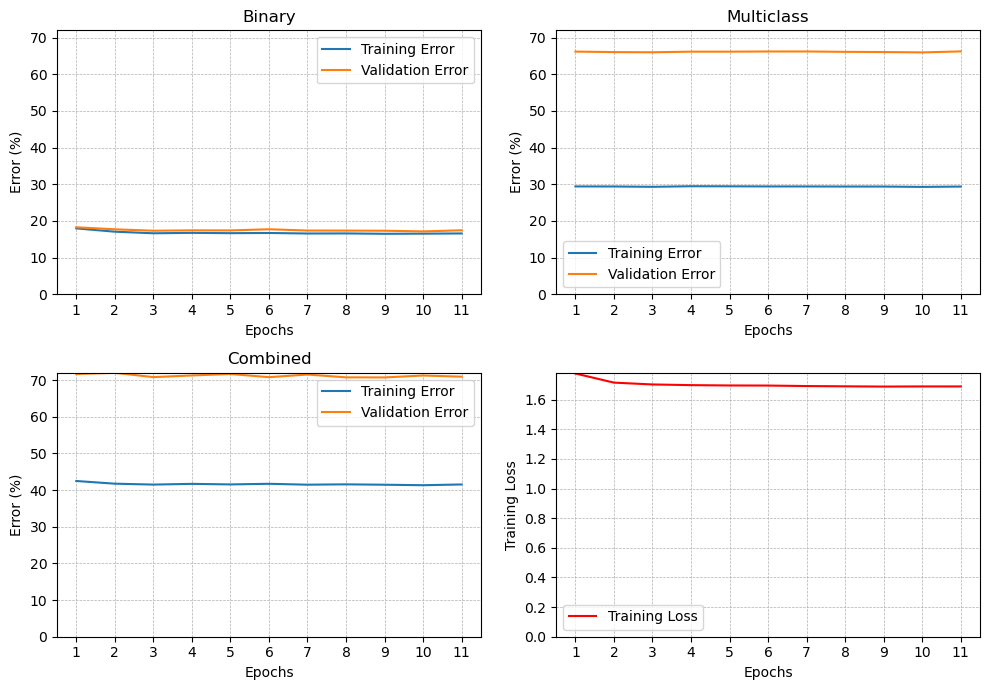